# they used KNN for labelling set generation


- These columns represent the raw ADC (Analog-to-Digital Converter) signal readings from 55 different segments (zones or pixels) of the Low-Energy Electronically-Chopped PIR sensor array.
Component	Role
PIR_1 to PIR_55	Raw features from motion sensors
Each column	Motion level in a specific location
Used for	Classifying occupancy (Label 0 or 1)
Preprocessing	Normalize, filter, zone aggregation
ML Methods	Classical (RF, LR), Deep (CNN, MLP)

## feature selection algorithm
- preprocessing technique
  - rescaling
  - binarization
  - 
- feature selection technique
  - univariate selection
  - recursive feature elimination
  - PCA
- what happens if we don't do any 

In [3]:
# standard scaler

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


df1 = pd.read_csv("pirvision_office_dataset1.csv")
df2 = pd.read_csv("pirvision_office_dataset2.csv")
df = pd.concat([df1,df2])


# df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
# # df.set_index('DateTime', inplace=True)

# pir_cols = [col for col in df.columns if 'PIR_' in col]
# scaler = StandardScaler()
# df[pir_cols] = scaler.fit_transform(df[pir_cols])

# # change the datatype in pandas
# #df['Date'] = df['Date'].astype('str')

# X = df[['Temperature_F',*pir_cols]]
# y = df['Label']

# # # Split the dataset
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# # Standardize features

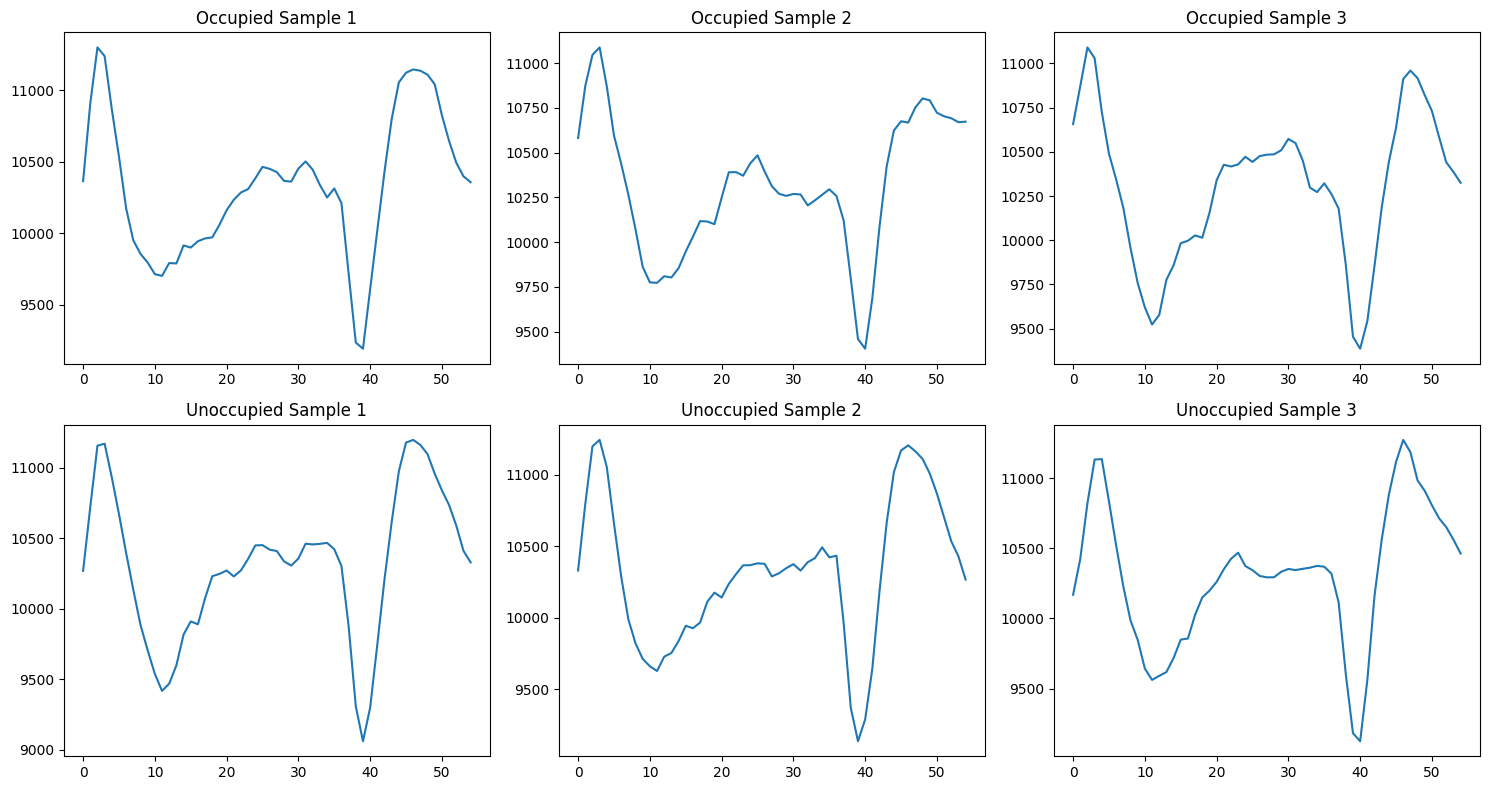

In [4]:
# Plot sample sequences
plt.figure(figsize=(15, 8))
for i in range(3):  # Plot 3 occupied and 3 unoccupied samples
    occupied_sample = df[df['Label'] == 1].iloc[i, 4:59].values
    unoccupied_sample = df[df['Label'] == 0].iloc[i, 4:59].values
    
    plt.subplot(2, 3, i+1)
    plt.plot(occupied_sample)
    plt.title(f'Occupied Sample {i+1}')
    
    plt.subplot(2, 3, i+4)
    plt.plot(unoccupied_sample)
    plt.title(f'Unoccupied Sample {i+1}')

plt.tight_layout()

Text(120.72222222222221, 0.5, 'Samples')

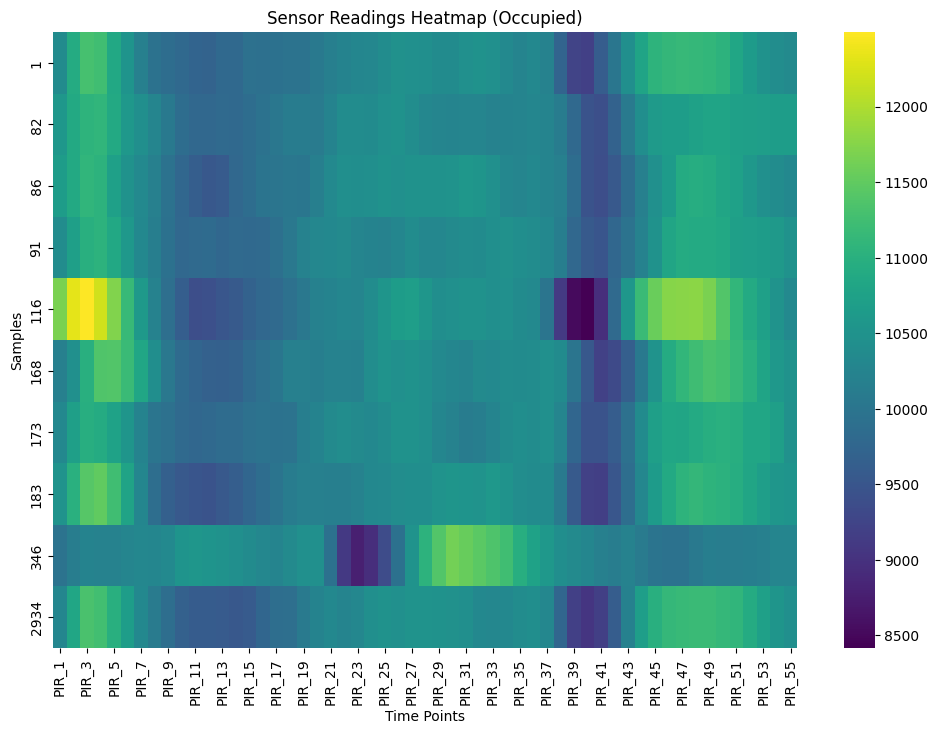

In [6]:
import seaborn as sns
plt.figure(figsize=(12, 8))
sns.heatmap(df[df['Label']==1].iloc[:10, 4:59], cmap='viridis')
plt.title('Sensor Readings Heatmap (Occupied)')
plt.xlabel('Time Points')
plt.ylabel('Samples')

Text(0.5, 1.0, 'Lag Correlation (PIR_1)')

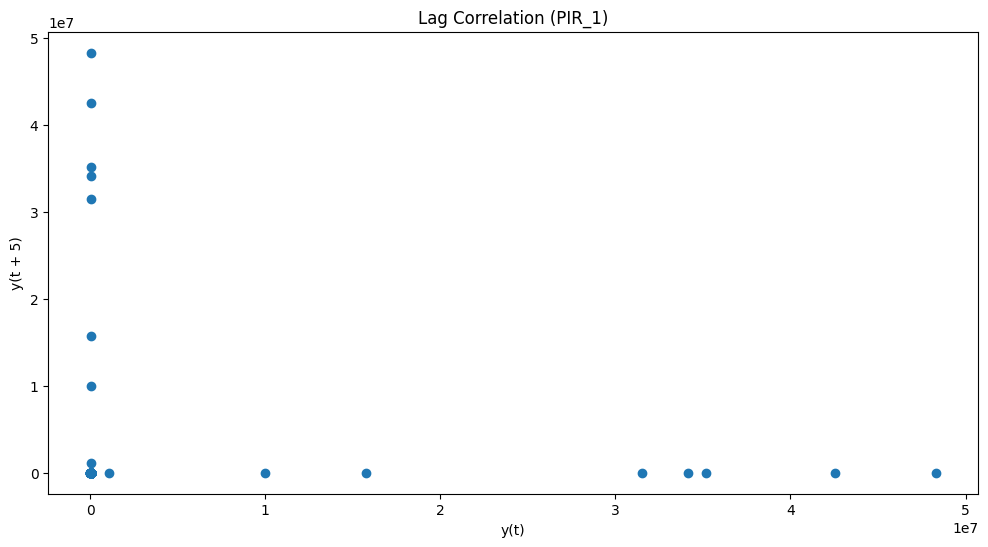

In [7]:
from pandas.plotting import lag_plot
plt.figure(figsize=(12, 6))
lag_plot(df['PIR_1'].iloc[:500], lag=5)  # Check autocorrelation at lag 5
plt.title('Lag Correlation (PIR_1)')

Text(0.5, 1.0, 'Z-Score Anomaly Detection')

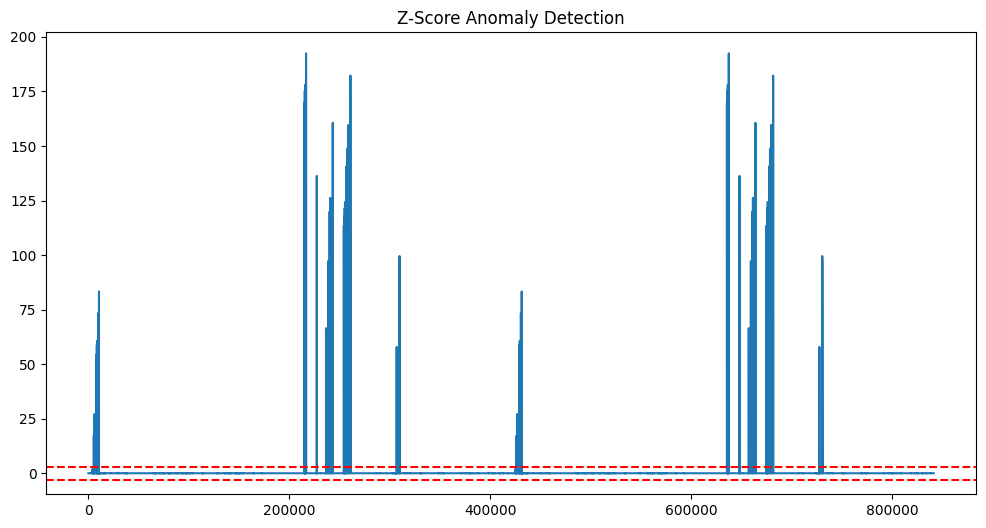

In [10]:
from scipy import stats
pir_cols = [col for col in df.columns if 'PIR_' in col]
z_scores = stats.zscore(df[pir_cols].values.flatten())
plt.figure(figsize=(12, 6))
plt.plot(z_scores)
plt.axhline(y=3, color='r', linestyle='--')
plt.axhline(y=-3, color='r', linestyle='--')
plt.title('Z-Score Anomaly Detection')

# how z-score will help?


Text(0.5, 0, 'Duration (seconds)')

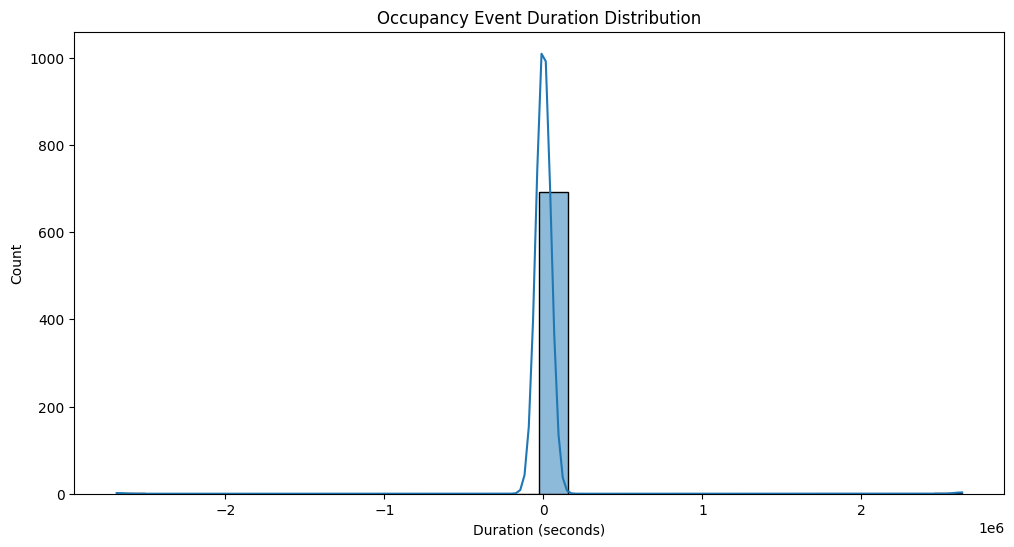

In [13]:
# Calculate occupancy durations
df['time'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
occupancy_changes = df[df['Label'].diff() != 0]
durations = occupancy_changes['time'].diff().dt.total_seconds()

plt.figure(figsize=(12, 6))
sns.histplot(durations.dropna(), bins=30, kde=True)
plt.title('Occupancy Event Duration Distribution')
plt.xlabel('Duration (seconds)')

<Axes: >

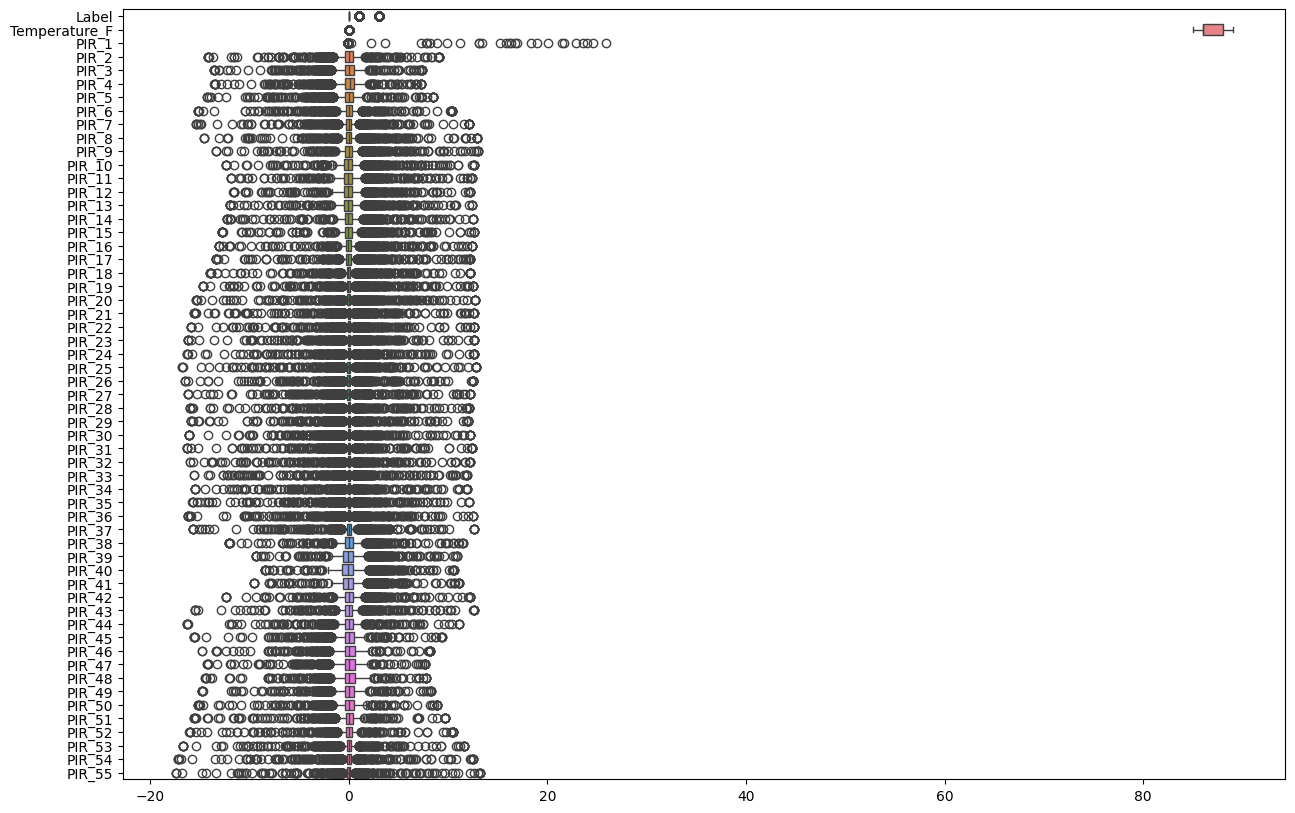

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize= (15,10))
sns.boxplot(data=df,orient="h")


## Understanding SleePIR sensor data
- Chopping Frequency: The sensor modulates IR signals at a fixed frequency (typically 1-10Hz)
- what is the time-domain and the frequency-domain
- Key Features:
  -  Baseline Drift: Slow changes due to ambient temperature.
  -  Peaks & Valleys: Sharp fluctuations indicate motion.
  -  Frequency Content: Human motion typically appears in 0.1Hz–5Hz range.

## Feature engineering
- FFT
- spatial entropy
- Over Time (per sequence of rows)

## Statistical & Pattern-Based Features (Over Time and Space)
- how this motion trend data will help me, in what ways?
- Each row is a 4-second snapshot of sensor readings (PIR_1 to PIR_55), but to capture motion trends and spatial activation, we can do more:
🔹 Over Space (per snapshot / row):
- what will heatmap of 55 sensor gives me.
- spatial entropy: Measures randomness of activation across sensors (low entropy = localized movement).

🔹 Over Time (per sequence of rows):
    - time based feature ideas
      - what are the benefits of creating a temporal window?
      - things to do:
        - moving average
        - delta / change detection
        - trend features : compute slope (rate of change) using LR for each sensor across time.
        - Fourier transform or DWT: from each sensor over time, capture 

## Sensor Correlation / Co-Activation
- correlation matrix
  - compute correlation between sensors
- PCA or t-sne
  - visualize patterns/clusters 
  - check which sensors contribute most to variance (principal components)

In [63]:
import scipy
# Example engineered features
df['mean_all'] = df[pir_cols].mean(axis=1)
df['std_all'] = df[pir_cols].std(axis=1)
#df['active_sensors'] = (df[pir_cols] > 200).sum(axis=1)
df['sensor_entropy'] = df[pir_cols].apply(lambda x: scipy.stats.entropy(x + 1e-6), axis=1)


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
pca = PCA(n_components=20) 
X_pca = pca.fit_transform(X_train)

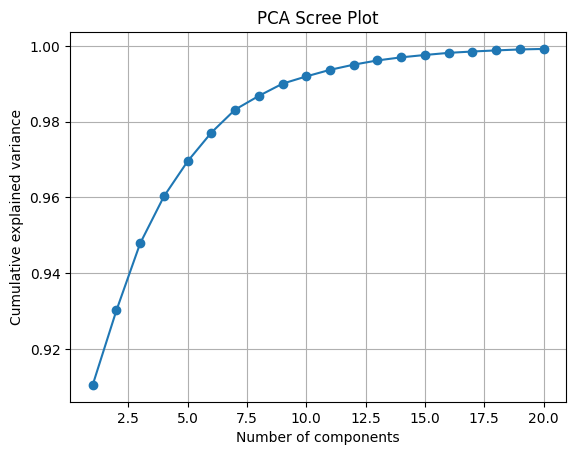

In [69]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA Scree Plot")
plt.grid()
plt.show()


In [71]:
df

,Date,Time,Label,Temperature_F,PIR_1,PIR_2,PIR_3,PIR_4,PIR_5,PIR_6,...,PIR_51,PIR_52,PIR_53,PIR_54,PIR_55,DateTime,mean_all,std_all,active_sensors,sensor_entropy
0,2024-08-08,19:19:56,0,86,-0.055875,-0.494950,-0.551045,-0.616061,-0.558023,-0.230890,...,-0.483428,-0.355541,-0.314113,-0.376149,-0.267425,2024-08-08 19:19:56,-0.031187,0.355426,0,-inf
1,2024-08-08,19:20:12,1,86,-0.055853,-0.180633,-0.333270,-0.513508,-0.663652,-0.484048,...,-0.510887,-0.529183,-0.513220,-0.404123,-0.205231,2024-08-08 19:20:12,-0.016895,0.428023,0,-inf
2,2024-08-08,19:20:28,0,86,-0.055861,-0.373279,-0.488606,-0.507475,-0.358319,-0.255089,...,-0.432172,-0.423068,-0.431114,-0.341720,-0.409584,2024-08-08 19:20:28,-0.033590,0.373442,0,-inf
3,2024-08-08,19:20:44,0,86,-0.055899,-0.995152,-1.059694,-0.671862,-0.219681,0.072528,...,-0.542007,-0.396057,-0.188902,-0.051221,0.030219,2024-08-08 19:20:44,-0.032713,0.448092,0,-inf
4,2024-08-08,19:21:00,0,86,-0.055863,-0.586203,-0.630236,-0.519540,-0.231234,0.035299,...,-0.525531,-0.318883,-0.318218,-0.339568,-0.094170,2024-08-08 19:21:00,-0.025424,0.373858,0,-inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7646,2024-10-08,04:34:17,0,88,-0.055787,0.777524,0.717533,0.471308,0.255647,0.122788,...,0.424540,0.404626,0.157995,0.028397,-0.025312,2024-10-08 04:34:17,0.030202,0.436951,0,-inf
7647,2024-10-08,04:34:33,0,88,-0.055842,0.116784,0.423613,0.635695,0.565931,0.379669,...,0.598445,0.354462,0.176469,0.060675,0.034661,2024-10-08 04:34:33,0.020790,0.383855,0,-inf
7648,2024-10-08,04:34:49,0,88,-0.055842,-0.395247,0.056593,0.424555,0.448750,0.569538,...,0.534375,0.584056,0.671156,0.695469,0.547765,2024-10-08 04:34:49,0.034559,0.395718,0,-inf
7649,2024-10-08,04:35:05,0,88,-0.055776,0.824841,0.767789,0.570845,0.275453,-0.001930,...,0.157275,-0.102795,-0.088322,-0.165269,-0.051966,2024-10-08 04:35:05,0.018721,0.396331,0,-inf


In [75]:
X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
df_pca_ready = pd.concat([X_pca_df, df['Label']], axis=1)  # Replace 'label' with your target column


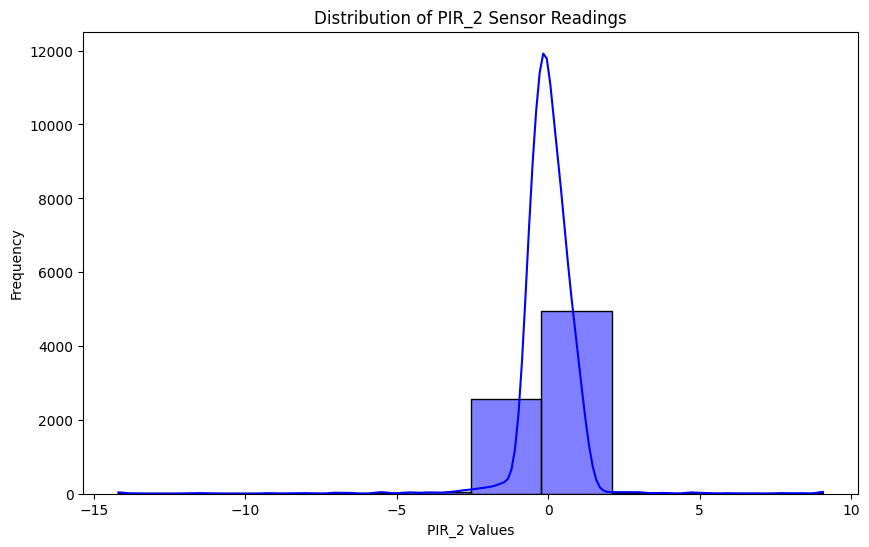

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# For a single PIR sensor (e.g., PIR_2)
plt.figure(figsize=(10, 6))
sns.histplot(df['PIR_2'], kde=True, bins=10, color='blue')
plt.title('Distribution of PIR_2 Sensor Readings')
plt.xlabel('PIR_2 Values')
plt.ylabel('Frequency')
plt.show()

# For multiple PIR sensors in a grid
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()

for i, col in enumerate(df.columns[4:16]):  # PIR_1 through PIR_12
    sns.histplot(df[col], kde=True, ax=axes[i], color='blue')
    axes[i].set_title(f'Distribution of {col}')
    
plt.tight_layout()
plt.show()


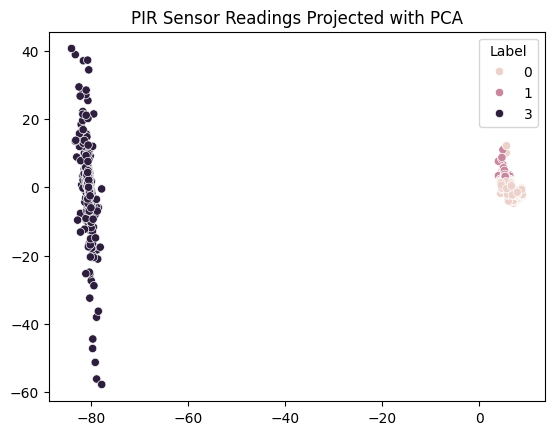

In [74]:
import seaborn as sns

sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_train)  # Label = Occupied or Not
plt.title("PIR Sensor Readings Projected with PCA")
plt.show()


- start with the normalization or standardization to ensure all readings are on a comparable scale.
- handling the sequential nature into a temporal order.
- engineer meaningful features from these raw readings such as statistical measures or temporal characteristics

Based on the description of the "LoginPIRvision_FoG_presence_detection" dataset and the techniques discussed:

The PIR Values (PIR_1 to PIR_55) in this dataset represent **55 raw analog sensor readings collected over a 4-second observation window**. These are **real-valued features**.

Drawing inspiration from the preprocessing steps used in the associated paper (though applied to a different sensor setup consisting of SLEEPIR voltage outputs and a single binary PIR signal), we can infer potential preprocessing techniques applicable to your PIR1-PIR55 data:

1.  **Normalization or Standardization:**
    *   The paper mentions **normalizing and zero-centering** their raw sensor data. This is a common preprocessing step to scale the features so that they have zero mean and unit variance. This ensures that features with different ranges do not disproportionately influence machine learning models, particularly distance-based algorithms like K-Nearest Neighbors (KNN) which is used in the paper. You can apply either standardization (using StandardScaler in Python's scikit-learn) or normalization (using MinMaxScaler) to the PIR1-PIR55 columns to bring them to a similar scale.

2.  **Handling Sequential Nature:**
    *   Since the 55 readings are collected over 4 seconds, they inherently have a temporal order. While the dataset is structured as tabular data where each row represents a 4-second interval, you might want to consider this sequential nature during preprocessing or feature engineering.

3.  **Feature Engineering from the Raw Readings:**
    *   Instead of directly using all 55 raw readings as features, you can engineer more meaningful features from them. This is aligned with the paper's approach of extracting six hand-crafted features from their 8-second windows of SLEEPIR and PIR data. Some potential feature engineering techniques for your PIR1-PIR55 data could include:
        *   **Statistical Measures:** Calculate statistics across the 55 readings for each 4-second observation. These could include:
            *   **Mean:** The average PIR reading over the 4 seconds.
            *   **Standard Deviation:** A measure of the variability in the PIR readings.
            *   **Minimum and Maximum:** The range of PIR values.
            *   **Percentiles (e.g., 25th, 50th, 75th):** To capture the distribution of the readings.
            *   **Variance:** The square of the standard deviation.
            *   **Skewness and Kurtosis:** Measures of the shape of the distribution.
        *   **Temporal Features:** Analyze the changes in readings over the 4 seconds:
            *   **Rate of Change:** Calculate the difference between consecutive readings or the overall trend.
            *   **Number of Peaks or Valleys:** Identify significant fluctuations in the signal.
            *   **Autocorrelation:** Analyze the correlation of the signal with a delayed version of itself.
        *   **Frequency Domain Analysis (if relevant):** If the fluctuations within the 4-second window have characteristic frequencies related to human activity, techniques like Fast Fourier Transform (FFT) could be applied to extract frequency-domain features.

4.  **Sliding Window (Potentially):**
    *   The paper uses an 8-second non-overlapping window. Your dataset already provides data in 4-second intervals. Depending on the machine learning task you want to perform (e.g., classifying occupancy based on longer durations), you might consider combining consecutive 4-second observations into larger windows and then extracting features from these larger windows. However, for a direct classification of each 4-second interval, this might not be necessary as an initial step.

5.  **Handling Missing Values:**
    *   The dataset information states that there are **no missing values**. Therefore, you likely won't need imputation techniques for these columns.

In summary, to preprocess the PIR1 to PIR55 columns:

*   **Start with normalization or standardization** to ensure all readings are on a comparable scale.
*   **Consider the temporal nature** of these 55 readings.
*   **Engineer meaningful features** from these raw readings, such as statistical measures or temporal characteristics.
*   Decide whether **windowing** (combining consecutive observations) is necessary based on your specific task.
*   Note that **missing value imputation** is likely not required.

The specific feature engineering techniques that will be most effective will depend on the patterns in the raw PIR sensor readings that are most discriminative of the different activity labels (Vacancy, Stationary human presence, Other activity/motion) in your target variable. You might need to experiment with different feature extraction methods to find the ones that yield the best performance for your chosen machine learning model.

In [13]:
# we will use the standard scaler for zero-centering and unit variance
from sklearn.preprocessing import StandardScaler
import numpy as np

# Select only PIR columns (PIR_1 to PIR_55)
pir_data = df.filter(regex='PIR_\d+').values  # Shape: (n_samples, 55)

# Standardize each PIR reading independently (per feature)
scaler = StandardScaler()
pir_standardized = scaler.fit_transform(pir_data)

# Alternative: Normalize per observation (if needed)
from sklearn.preprocessing import MinMaxScaler
normalized_per_obs = np.apply_along_axis(
    lambda x: MinMaxScaler().fit_transform(x.reshape(-1, 1)).flatten(),
    axis=1,
    arr=pir_data
)

In [5]:
pir_standardized

array([[-0.05587524, -0.49494956, -0.55104463, ..., -0.31411316,
        -0.37614925, -0.26742529],
       [-0.05585311, -0.18063326, -0.33326959, ..., -0.51321955,
        -0.40412321, -0.20523098],
       [-0.05586127, -0.37327873, -0.48860563, ..., -0.43111383,
        -0.34171976, -0.40958374],
       ...,
       [-0.05584193, -0.39524708,  0.05659341, ...,  0.67115557,
         0.69546858,  0.54776453],
       [-0.05577554,  0.82484091,  0.7677888 , ..., -0.08832241,
        -0.16526863, -0.0519664 ],
       [-0.05582539,  0.36012596,  0.57742601, ...,  0.51310205,
         0.32750342,  0.1212892 ]])

In [15]:
from scipy.stats import linregress
from scipy.signal import find_peaks
import scipy

def extract_temporal_features(signal):
    # Rate of change (slope of linear fit)
    slope, _, _, _, _ = linregress(np.arange(len(signal)), signal)
    
    # Autocorrelation (lag=1)
    autocorr = np.corrcoef(signal[:-1], signal[1:])[0, 1]
    
    # Peak/valley counts
    peaks, _ = find_peaks(signal, prominence=30)
    valleys, _ = find_peaks(-signal, prominence=30)
    
    return {
        'temporal_slope': slope,
        'autocorrelation_lag1': autocorr,
        'n_peaks': len(peaks),
        'n_valleys': len(valleys),
        'peak_valley_ratio': len(peaks)/(len(valleys)+1e-10)  # Avoid division by zero
    }

## Feature engineering

In [16]:
def extract_statistical_features(signal):
    return {
        'mean': np.mean(signal),
        'std': np.std(signal),
        'min': np.min(signal),
        'max': np.max(signal),
        'range': np.ptp(signal),  # Peak-to-peak
        'percentile_25': np.percentile(signal, 25),
        'percentile_50': np.median(signal),
        'percentile_75': np.percentile(signal, 75),
        'variance': np.var(signal),
        'skewness': scipy.stats.skew(signal),
        'kurtosis': scipy.stats.kurtosis(signal),
        'rms': np.sqrt(np.mean(signal**2))  # Root Mean Square
    }

In [17]:
def extract_frequency_features(signal, sampling_rate=55/4):  # 55 samples over 4 sec
    fft_vals = np.abs(np.fft.rfft(signal))
    freqs = np.fft.rfftfreq(len(signal), d=1/sampling_rate)
    
    # Energy in different bands (human motion typically 0.1-5Hz)
    mask_low = (freqs >= 0.1) & (freqs < 1)
    mask_high = (freqs >= 1) & (freqs < 5)
    
    return {
        'dominant_freq': freqs[np.argmax(fft_vals)],
        'spectral_energy': np.sum(fft_vals**2),
        'energy_0.1_1hz': np.sum(fft_vals[mask_low]**2),
        'energy_1_5hz': np.sum(fft_vals[mask_high]**2),
        'spectral_entropy': scipy.stats.entropy(fft_vals + 1e-10)  # Add small epsilon
    }

In [20]:
def extract_all_features(signal):
    features = {}
    features.update(extract_statistical_features(signal))
    features.update(extract_temporal_features(signal))
    features.update(extract_frequency_features(signal))
    return features

# Apply to entire dataset
feature_list = [extract_all_features(row) for row in pir_standardized]
feature_df = pd.DataFrame(feature_list)
feature_df['Label'] = df['Label'].reset_index(drop=True)
  # Preserve labels

In [19]:
feature_df

,mean,std,min,max,range,percentile_25,percentile_50,percentile_75,variance,skewness,...,temporal_slope,autocorrelation_lag1,n_peaks,n_valleys,peak_valley_ratio,dominant_freq,spectral_energy,energy_0.1_1hz,energy_1_5hz,spectral_entropy
0,-0.031187,0.352180,-0.616061,0.525723,1.141784,-0.332088,0.013493,0.229482,0.124031,-0.099394,...,-0.006546,0.897769,0,0,0.0,0.5,190.538856,132.129982,54.623345,2.725575
1,-0.016895,0.424114,-0.663652,0.930333,1.593985,-0.287818,-0.137586,0.195980,0.179872,0.531036,...,-0.006629,0.911009,0,0,0.0,0.5,272.920295,155.258396,116.023412,2.478228
2,-0.033590,0.370031,-0.612848,0.656956,1.269803,-0.352619,-0.106080,0.198524,0.136923,0.391313,...,-0.007526,0.932388,0,0,0.0,0.5,210.509301,164.630062,40.712955,2.510830
3,-0.032713,0.443999,-1.059694,0.946753,2.006447,-0.320572,-0.040657,0.199517,0.197135,-0.008120,...,-0.007001,0.866746,0,0,0.0,0.5,301.404414,166.123428,130.661896,2.764996
4,-0.025424,0.370444,-0.759362,0.665517,1.424879,-0.309983,-0.052796,0.272671,0.137228,0.027321,...,-0.006463,0.866401,0,0,0.0,0.5,209.513357,123.542189,82.933212,2.704209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15297,0.030202,0.432960,-0.883522,0.777524,1.661046,-0.227719,0.074163,0.395363,0.187455,-0.426574,...,0.007422,0.888681,0,0,0.0,0.5,286.284597,155.077221,126.480926,2.684050
15298,0.020790,0.380349,-0.797410,0.643962,1.441372,-0.259475,0.053436,0.271930,0.144665,-0.205103,...,0.005626,0.875833,0,0,0.0,1.0,220.113993,83.670383,134.541592,2.627274
15299,0.034559,0.392105,-0.918831,0.695469,1.614300,-0.282307,0.031659,0.394586,0.153746,-0.282984,...,0.007549,0.850430,0,0,0.0,0.5,236.153653,115.216438,116.931638,2.782647
15300,0.018721,0.392711,-0.758933,0.824841,1.583774,-0.174240,-0.031297,0.208363,0.154222,0.249905,...,0.004436,0.858492,0,0,0.0,0.5,234.321085,108.223584,122.547669,2.795671


In [22]:
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 5. Model Training
X = feature_df.drop('Label', axis=1)
y = feature_df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# KNN model (as per paper)
knn = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier(n_neighbors=5)
)
knn.fit(X_train, y_train)
print("KNN Performance:")
print(classification_report(y_test, knn.predict(X_test)))
print(accuracy_score(y_test, knn.predict(X_test)))

KNN Performance:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3753
           1       0.83      0.92      0.87       486
           3       0.96      0.76      0.85       352

    accuracy                           0.97      4591
   macro avg       0.93      0.89      0.90      4591
weighted avg       0.97      0.97      0.97      4591

0.9681986495316924


In [23]:
# Random Forest comparison
rf = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(n_estimators=100)
)
rf.fit(X_train, y_train)
print("\nRandom Forest Performance:")
y_pred = knn.predict(X_test)

print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))


Random Forest Performance:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3753
           1       0.83      0.92      0.87       486
           3       0.96      0.76      0.85       352

    accuracy                           0.97      4591
   macro avg       0.93      0.89      0.90      4591
weighted avg       0.97      0.97      0.97      4591

0.9681986495316924


Key Implementation Notes
Normalization Strategy:

The paper uses standardization (zero mean, unit variance), so StandardScaler is preferred.

If using distance-based models (like KNN), standardization is crucial.

Temporal Features:

The autocorrelation and slope features capture motion dynamics.

Peak/valley counts detect abrupt changes (characteristic of human motion).

Frequency Features:

Human motion typically appears in 0.1-5Hz range.

Spectral energy in these bands helps distinguish occupancy.

Model Choice:

The paper uses KNN, but Random Forest often performs better with engineered features.

Always compare multiple models.


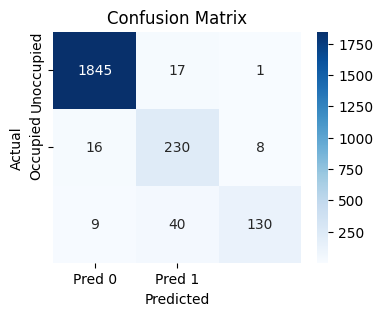

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Example true labels and predictions
# y_true = [1, 0, 1, 1, 0, 1, 0, 0, 1, 0]
# y_pred = [1, 0, 0, 1, 0, 1, 1, 0, 1, 0]

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Pred 0", "Pred 1","Pred 3"], yticklabels=["Unoccupied", "Occupied"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [106]:
df

,Date,Time,Label,Temperature_F,PIR_1,PIR_2,PIR_3,PIR_4,PIR_5,PIR_6,...,PIR_51,PIR_52,PIR_53,PIR_54,PIR_55,DateTime,mean_all,std_all,active_sensors,sensor_entropy
0,2024-08-08,19:19:56,0,86,-0.055875,-0.494950,-0.551045,-0.616061,-0.558023,-0.230890,...,-0.483428,-0.355541,-0.314113,-0.376149,-0.267425,2024-08-08 19:19:56,-0.031187,0.355426,0,-inf
1,2024-08-08,19:20:12,1,86,-0.055853,-0.180633,-0.333270,-0.513508,-0.663652,-0.484048,...,-0.510887,-0.529183,-0.513220,-0.404123,-0.205231,2024-08-08 19:20:12,-0.016895,0.428023,0,-inf
2,2024-08-08,19:20:28,0,86,-0.055861,-0.373279,-0.488606,-0.507475,-0.358319,-0.255089,...,-0.432172,-0.423068,-0.431114,-0.341720,-0.409584,2024-08-08 19:20:28,-0.033590,0.373442,0,-inf
3,2024-08-08,19:20:44,0,86,-0.055899,-0.995152,-1.059694,-0.671862,-0.219681,0.072528,...,-0.542007,-0.396057,-0.188902,-0.051221,0.030219,2024-08-08 19:20:44,-0.032713,0.448092,0,-inf
4,2024-08-08,19:21:00,0,86,-0.055863,-0.586203,-0.630236,-0.519540,-0.231234,0.035299,...,-0.525531,-0.318883,-0.318218,-0.339568,-0.094170,2024-08-08 19:21:00,-0.025424,0.373858,0,-inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7646,2024-10-08,04:34:17,0,88,-0.055787,0.777524,0.717533,0.471308,0.255647,0.122788,...,0.424540,0.404626,0.157995,0.028397,-0.025312,2024-10-08 04:34:17,0.030202,0.436951,0,-inf
7647,2024-10-08,04:34:33,0,88,-0.055842,0.116784,0.423613,0.635695,0.565931,0.379669,...,0.598445,0.354462,0.176469,0.060675,0.034661,2024-10-08 04:34:33,0.020790,0.383855,0,-inf
7648,2024-10-08,04:34:49,0,88,-0.055842,-0.395247,0.056593,0.424555,0.448750,0.569538,...,0.534375,0.584056,0.671156,0.695469,0.547765,2024-10-08 04:34:49,0.034559,0.395718,0,-inf
7649,2024-10-08,04:35:05,0,88,-0.055776,0.824841,0.767789,0.570845,0.275453,-0.001930,...,0.157275,-0.102795,-0.088322,-0.165269,-0.051966,2024-10-08 04:35:05,0.018721,0.396331,0,-inf


Unique labels: [0 1 3]
Epoch 1/50, Loss: 0.2565, Val Loss: 0.0465
Epoch 2/50, Loss: 0.0615, Val Loss: 0.0554
Epoch 3/50, Loss: 0.0453, Val Loss: 0.0561
Epoch 4/50, Loss: 0.0432, Val Loss: 0.0493
Epoch 5/50, Loss: 0.0397, Val Loss: 0.0394
Epoch 6/50, Loss: 0.0356, Val Loss: 0.0366
Epoch 7/50, Loss: 0.0333, Val Loss: 0.0378
Epoch 8/50, Loss: 0.0324, Val Loss: 0.0518
Epoch 9/50, Loss: 0.0350, Val Loss: 0.0348
Epoch 10/50, Loss: 0.0292, Val Loss: 0.0322
Epoch 11/50, Loss: 0.0284, Val Loss: 0.0411
Epoch 12/50, Loss: 0.0304, Val Loss: 0.0359
Epoch 13/50, Loss: 0.0310, Val Loss: 0.0438
Epoch 14/50, Loss: 0.0301, Val Loss: 0.0349
Epoch 15/50, Loss: 0.0305, Val Loss: 0.0310
Epoch 16/50, Loss: 0.0304, Val Loss: 0.0328
Epoch 17/50, Loss: 0.0296, Val Loss: 0.0323
Epoch 18/50, Loss: 0.0293, Val Loss: 0.0306
Epoch 19/50, Loss: 0.0274, Val Loss: 0.0423
Epoch 20/50, Loss: 0.0272, Val Loss: 0.0353
Epoch 21/50, Loss: 0.0264, Val Loss: 0.0277
Epoch 22/50, Loss: 0.0263, Val Loss: 0.0348
Epoch 23/50, Loss:

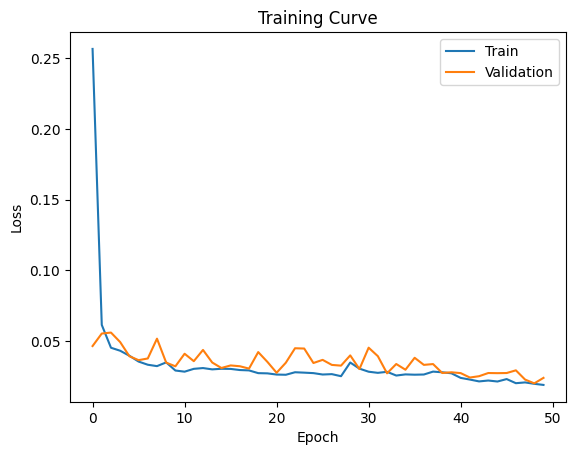

Train Accuracy: 0.9925
Test Accuracy: 0.9915


In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Load and inspect data
#df = pd.read_csv('PIRvision_data.csv')
pir_cols = [f'PIR_{i}' for i in range(1, 56)]
pir_cols.append('Temperature_F')
X = df[pir_cols].values
y = df['Label'].values

# Check unique labels and adjust if needed
print("Unique labels:", np.unique(y))
num_classes = len(np.unique(y))

# 2. Standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_reshaped = X_scaled.reshape(-1, 56, 1)  # [samples, seq_len, features]

# 3. Convert labels to 0-indexed if needed
if y.min() > 0:
    y = y - y.min()  # Convert to 0-indexed

le = LabelEncoder()
y = le.fit_transform(y)  # Converts to 0-indexed automatically

# 4. Convert to PyTorch tensors
X_tensor = torch.FloatTensor(X_reshaped)
y_tensor = torch.LongTensor(y)  # For CrossEntropyLoss

# 5. Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_tensor, y_tensor, test_size=0.2, random_state=42
)

# 6. Create DataLoaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# 7. Define LSTM Model
class OccupancyLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_classes=2):
        super(OccupancyLSTM, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, num_classes)
        )
        
    def forward(self, x):
        out, _ = self.lstm(x)  # out: [batch, seq_len, hidden_size]
        out = out[:, -1, :]     # Take last timestep
        return self.fc(out)

model = OccupancyLSTM(num_classes=num_classes)

# 8. Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 9. Training loop
def train_model(model, num_epochs=50):
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        val_epoch_loss = val_loss / len(test_loader)
        train_losses.append(epoch_loss)
        val_losses.append(val_epoch_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Val Loss: {val_epoch_loss:.4f}')
    
    return train_losses, val_losses

train_losses, val_losses = train_model(model)

# 10. Plot training
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('Training Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 11. Evaluation
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

print(f'Train Accuracy: {evaluate(model, train_loader):.4f}')
print(f'Test Accuracy: {evaluate(model, test_loader):.4f}')

In [114]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import seaborn as sns

def evaluate_with_metrics(model, loader, num_classes):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            if num_classes == 1:  # Binary classification
                preds = (torch.sigmoid(outputs) > 0.5).long()
            else:  # Multi-class classification
                _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='binary' if num_classes == 1 else 'weighted'
    )
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    return {
        'accuracy': sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels),
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm
    }

# Usage example (after training)
metrics_train = evaluate_with_metrics(model, train_loader, num_classes)
metrics_test = evaluate_with_metrics(model, test_loader, num_classes)

print("\nTraining Metrics:")
print(f"Accuracy: {metrics_train['accuracy']:.4f}")
print(f"Precision: {metrics_train['precision']:.4f}")
print(f"Recall: {metrics_train['recall']:.4f}")
print(f"F1 Score: {metrics_train['f1']:.4f}")

print("\nTest Metrics:")
print(f"Accuracy: {metrics_test['accuracy']:.4f}")
print(f"Precision: {metrics_test['precision']:.4f}")
print(f"Recall: {metrics_test['recall']:.4f}")
print(f"F1 Score: {metrics_test['f1']:.4f}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(metrics_test['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
            xticklabels=['Unoccupied', 'Occupied'] if num_classes == 2 else None,
            yticklabels=['Unoccupied', 'Occupied'] if num_classes == 2 else None)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Training Metrics:
Accuracy: 0.9912
Precision: 0.9911
Recall: 0.9912
F1 Score: 0.9911

Test Metrics:
Accuracy: 0.9869
Precision: 0.9868
Recall: 0.9869
F1 Score: 0.9867


TypeError: object of type 'NoneType' has no len()

<Figure size 800x600 with 0 Axes>

Epoch 1/50 | Train Loss: 0.0295 | Val F1: 0.9834 | Val Recall: 0.9830
Epoch 2/50 | Train Loss: 0.0262 | Val F1: 0.9847 | Val Recall: 0.9850
Epoch 3/50 | Train Loss: 0.0273 | Val F1: 0.9895 | Val Recall: 0.9895
Epoch 4/50 | Train Loss: 0.0266 | Val F1: 0.9880 | Val Recall: 0.9882
Epoch 5/50 | Train Loss: 0.0283 | Val F1: 0.9864 | Val Recall: 0.9863
Epoch 6/50 | Train Loss: 0.0274 | Val F1: 0.9846 | Val Recall: 0.9850
Epoch 7/50 | Train Loss: 0.0272 | Val F1: 0.9908 | Val Recall: 0.9909
Epoch 8/50 | Train Loss: 0.0308 | Val F1: 0.9901 | Val Recall: 0.9902
Epoch 9/50 | Train Loss: 0.0288 | Val F1: 0.9902 | Val Recall: 0.9902
Epoch 10/50 | Train Loss: 0.0257 | Val F1: 0.9901 | Val Recall: 0.9902
Epoch 11/50 | Train Loss: 0.0251 | Val F1: 0.9895 | Val Recall: 0.9895
Epoch 12/50 | Train Loss: 0.0236 | Val F1: 0.9908 | Val Recall: 0.9909
Epoch 13/50 | Train Loss: 0.0292 | Val F1: 0.9894 | Val Recall: 0.9895
Epoch 14/50 | Train Loss: 0.0254 | Val F1: 0.9887 | Val Recall: 0.9889
Epoch 15/50 | T

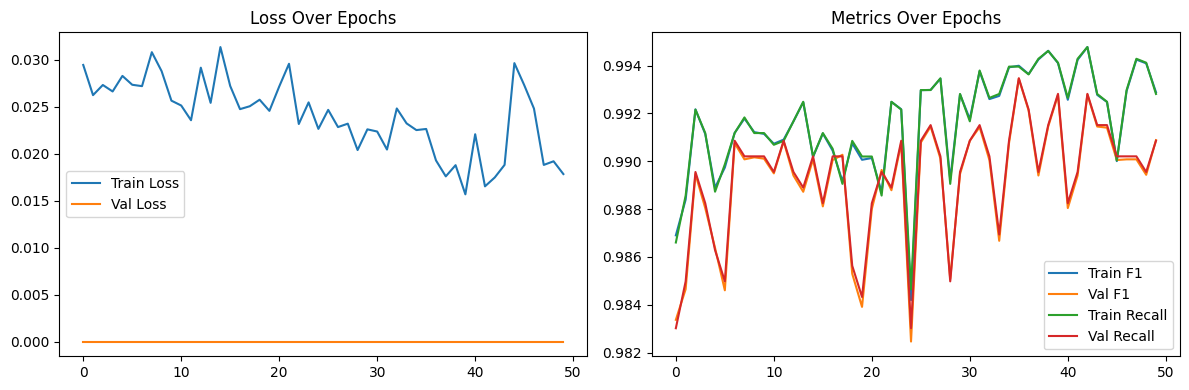

In [115]:
def train_model_with_metrics(model, num_epochs=50):
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_f1': [],
        'val_f1': [],
        'train_recall': [],
        'val_recall': []
    }
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Evaluation phase
        train_metrics = evaluate_with_metrics(model, train_loader, num_classes)
        val_metrics = evaluate_with_metrics(model, test_loader, num_classes)
        
        # Record metrics
        history['train_loss'].append(train_loss/len(train_loader))
        history['val_loss'].append(val_metrics.get('loss', 0))  # If you track loss
        history['train_f1'].append(train_metrics['f1'])
        history['val_f1'].append(val_metrics['f1'])
        history['train_recall'].append(train_metrics['recall'])
        history['val_recall'].append(val_metrics['recall'])
        
        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {history['train_loss'][-1]:.4f} | "
              f"Val F1: {history['val_f1'][-1]:.4f} | "
              f"Val Recall: {history['val_recall'][-1]:.4f}")
    
    return history


def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss Over Epochs')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_f1'], label='Train F1')
    plt.plot(history['val_f1'], label='Val F1')
    plt.plot(history['train_recall'], label='Train Recall')
    plt.plot(history['val_recall'], label='Val Recall')
    plt.title('Metrics Over Epochs')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Usage
history = train_model_with_metrics(model)
plot_training_history(history)



In [113]:
print(y_test.shape,y_pred.shape)

torch.Size([1531]) (2296,)


Original label values: [0 1 3]
Processed label values: [0 1 2]
Number of classes: 3
Epoch 1/50, Train Loss: 0.3390, Val Loss: 0.1852
Epoch 2/50, Train Loss: 0.1463, Val Loss: 0.1304
Epoch 3/50, Train Loss: 0.1117, Val Loss: 0.1544
Epoch 4/50, Train Loss: 0.0978, Val Loss: 0.1291
Epoch 5/50, Train Loss: 0.0911, Val Loss: 0.1135
Epoch 6/50, Train Loss: 0.0854, Val Loss: 0.1344
Epoch 7/50, Train Loss: 0.0864, Val Loss: 0.1264
Epoch 8/50, Train Loss: 0.0779, Val Loss: 0.0953
Epoch 9/50, Train Loss: 0.0765, Val Loss: 0.1130
Epoch 10/50, Train Loss: 0.0623, Val Loss: 0.1388
Epoch 11/50, Train Loss: 0.0813, Val Loss: 0.1256
Epoch 12/50, Train Loss: 0.0581, Val Loss: 0.1219
Epoch 13/50, Train Loss: 0.0629, Val Loss: 0.1205
Epoch 14/50, Train Loss: 0.0565, Val Loss: 0.0989
Epoch 15/50, Train Loss: 0.0567, Val Loss: 0.1865
Epoch 16/50, Train Loss: 0.0559, Val Loss: 0.1207
Epoch 17/50, Train Loss: 0.0595, Val Loss: 0.1163
Epoch 18/50, Train Loss: 0.0504, Val Loss: 0.0947
Epoch 19/50, Train Loss: 

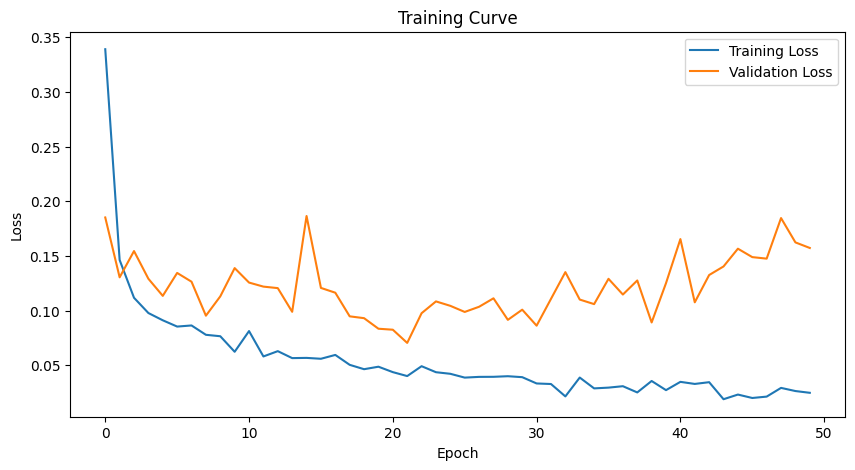


Training Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9998
           1       1.00      1.00      1.00      1325
           3       1.00      1.00      1.00       907

    accuracy                           1.00     12230
   macro avg       1.00      1.00      1.00     12230
weighted avg       1.00      1.00      1.00     12230


Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2483
           1       0.94      0.94      0.94       340
           3       0.94      0.94      0.94       235

    accuracy                           0.99      3058
   macro avg       0.96      0.96      0.96      3058
weighted avg       0.99      0.99      0.99      3058



In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# 1. Load and inspect data
#df = pd.read_csv('PIRvision_data.csv')
pir_cols = [f'PIR_{i}' for i in range(1, 56)]
X = df[pir_cols].values
y = df['Label'].values

# 2. Process labels to ensure proper formatting
print("Original label values:", np.unique(y))
le = LabelEncoder()
y = le.fit_transform(y)  # Converts to 0-indexed integers
num_classes = len(np.unique(y))
print("Processed label values:", np.unique(y))
print("Number of classes:", num_classes)

# 3. Standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Create sliding windows (fixed implementation)
def create_sliding_windows(data, window_size=15, step=1):
    """Create sliding windows from 2D time-series data"""
    num_samples = data.shape[0]  # Use shape[0] instead of len() for numpy arrays
    windows = []
    for i in range(0, num_samples - window_size + 1, step):
        windows.append(data[i:i+window_size])
    return np.array(windows)

window_size = 15
X_windows = create_sliding_windows(X_scaled, window_size=window_size)
y_windows = y[window_size-1:]  # Assign label to last element of window

# 5. Flatten windows for ANN
X_ann = X_windows.reshape(X_windows.shape[0], -1)  # (n_samples, window_size*55)
input_size = X_ann.shape[1]

# 6. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_ann, y_windows, test_size=0.2, random_state=42
)

# 7. Convert to PyTorch tensors
X_train_t = torch.FloatTensor(X_train)
X_test_t = torch.FloatTensor(X_test)
y_train_t = torch.LongTensor(y_train)  # CrossEntropyLoss expects LongTensor
y_test_t = torch.LongTensor(y_test)

# 8. Create DataLoaders
train_dataset = TensorDataset(X_train_t, y_train_t)
test_dataset = TensorDataset(X_test_t, y_test_t)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# 9. Define ANN Model
class WindowedANN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(WindowedANN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)  # Output size matches num_classes
        )
    
    def forward(self, x):
        return self.fc(x)

# Initialize model
model = WindowedANN(input_size=input_size, num_classes=num_classes)

# 10. Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 11. Training loop
def train_model(model, num_epochs=50):
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        val_epoch_loss = val_loss / len(test_loader)
        train_losses.append(epoch_loss)
        val_losses.append(val_epoch_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_epoch_loss:.4f}')
    
    return train_losses, val_losses

train_losses, val_losses = train_model(model)

# 12. Plot training
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 13. Evaluation
def evaluate(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.numpy())
    
    return all_preds, all_labels

train_preds, train_labels = evaluate(model, train_loader)
test_preds, test_labels = evaluate(model, test_loader)

print("\nTraining Classification Report:")
print(classification_report(train_labels, train_preds, target_names=[str(cls) for cls in le.classes_]))

print("\nTest Classification Report:")
print(classification_report(test_labels, test_preds, target_names=[str(cls) for cls in le.classes_]))